<a href="https://colab.research.google.com/github/khanmhmdi/Moe-llm-edge-computing/blob/main/Copy_of_BDD100k_Object_tracking_dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
solesensei_solesensei_bdd100k_path = kagglehub.dataset_download('solesensei/solesensei_bdd100k')

print('Data source import complete.')


100%|██████████| 7.61G/7.61G [01:17<00:00, 106MB/s]

Extracting files...


Data source import complete.


In [ ]:
print(solesensei_solesensei_bdd100k_path)

/root/.cache/kagglehub/datasets/solesensei/solesensei_bdd100k/versions/2


In [ ]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torchvision.ops import generalized_box_iou

class BDD100KDetectionDataset(Dataset):
    def __init__(self, image_dir, label_path, transforms=None, target_size=(640, 640)):
        self.image_dir = image_dir
        self.transforms = transforms
        self.target_size = target_size

        # Load annotations
        with open(label_path) as f:
            self.annotations = json.load(f)
        print(f"Initial annotations: {len(self.annotations)}")

        # Build image path mapping with case-insensitive check
        self.image_paths = {}
        for root, dirs, files in os.walk(image_dir):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    key = os.path.basename(file)  # Match annotation filenames without paths
                    self.image_paths[key] = os.path.join(root, file)
        print(f"Discovered images: {len(self.image_paths)}")

        # Filter annotations using basename
        self.valid_annotations = []
        for ann in self.annotations:
            ann_filename = os.path.basename(ann['name'])
            if ann_filename in self.image_paths:
                self.valid_annotations.append(ann)

        print(f"Valid annotations after filtering: {len(self.valid_annotations)}")

        if len(self.valid_annotations) == 0:
            raise RuntimeError("No valid images+annotations pairs found. Check:")

        # Class labels (BDD100K 10-class detection)
        self.CLASSES = [
            'pedestrian', 'rider', 'car', 'truck', 'bus',
            'train', 'motorcycle', 'bicycle', 'traffic light', 'traffic sign'
        ]
        self.label_map = {name: idx for idx, name in enumerate(self.CLASSES)}

        # Default transforms
        if self.transforms is None:
            self.transforms = T.Compose([
                T.Resize(self.target_size),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.valid_annotations)

    def __getitem__(self, idx):
        ann = self.valid_annotations[idx]
        img_path = self.image_paths[ann['name']]

        # Load image
        image = Image.open(img_path).convert('RGB')
        original_size = image.size  # (width, height)

        # Apply transforms
        image = self.transforms(image)

        # Extract bounding boxes and labels
        boxes = []
        labels = []
        for obj in ann.get('labels', []):
            if 'box2d' in obj and obj['category'] in self.label_map:
                box = obj['box2d']
                # Convert to [x_min, y_min, x_max, y_max] format
                boxes.append([box['x1'], box['y1'], box['x2'], box['y2']])
                labels.append(self.label_map[obj['category']])

        if len(boxes) == 0:
            # Handle images without valid objects
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            # boxes[:, [0, 2]] /= original_size[0]  # width
            # boxes[:, [1, 3]] /= original_size[1]  # height
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'orig_size': torch.tensor(original_size)
        }

        return image, target

def collate_fn(batch):
    return tuple(zip(*batch))


####################################################################################################################################################3
train_image_dir = '/root/.cache/kagglehub/datasets/solesensei/solesensei_bdd100k/versions/2/bdd100k/bdd100k/images/100k/train'
train_label_path = '/root/.cache/kagglehub/datasets/solesensei/solesensei_bdd100k/versions/2/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_train.json'

train_dataset = BDD100KDetectionDataset(
    image_dir=train_image_dir,
    label_path=train_label_path
)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)
####################################################################################################################################################3

# Test one batch
for images, targets in train_loader:
    print(f"Batch size: {len(images)}")
    print(f"Image shape: {images[0].shape}")
    print(f"Number of boxes in first image: {len(targets[0]['boxes'])}")
    break

Initial annotations: 69863
Discovered images: 70000
Valid annotations after filtering: 69863


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch size: 8
Image shape: torch.Size([3, 640, 640])
Number of boxes in first image: 8


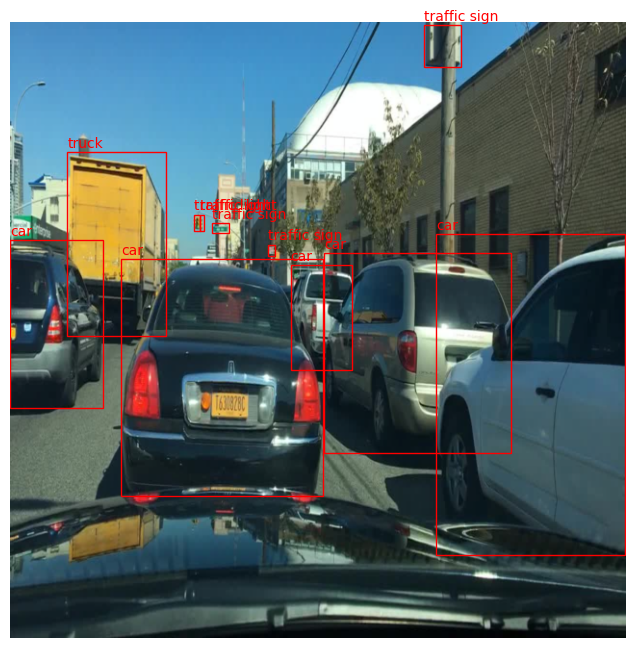

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as F

def plot_sample(image, target, classes, threshold=0.5):
    # Denormalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image.numpy().transpose((1, 2, 0))  # CHW -> HWC
    image = std * image + mean
    image = np.clip(image, 0, 1)

    # Create figure
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    # Get scaling factors
    orig_width, orig_height = target['orig_size'].numpy()
    current_height, current_width = image.shape[:2]
    scale_x = current_width / orig_width
    scale_y = current_height / orig_height

    # Plot boxes
    for box, label in zip(target['boxes'], target['labels']):
        # Scale box coordinates
        x1 = box[0] * scale_x
        y1 = box[1] * scale_y
        x2 = box[2] * scale_x
        y2 = box[3] * scale_y

        # Create rectangle
        rect = plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)

        # Add label
        label_text = classes[label]
        ax.text(
            x1, y1 - 5, label_text,
            color='r', fontsize=10, backgroundcolor='none'
        )

    plt.axis('off')
    plt.show()

# Get a batch from the DataLoader
images, targets = next(iter(train_loader))

# Plot first sample
image = images[0].cpu()
target = targets[0]
plot_sample(image, target, train_dataset.CLASSES)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

class SwitchMoEPredictor(nn.Module):
    """
    A 'Switch' Mixture-of-Experts predictor for Faster R-CNN.
    We replicate the standard FastRCNNPredictor multiple times (num_experts).
    Then, for each ROI feature, we compute gating logits and route it to a single expert.

    Args:
        in_channels (int): Number of input channels (e.g. 1024 for ResNet50-FPN).
        num_classes (int): Number of detection classes (including background).
        num_experts (int): How many expert heads to instantiate.
    """
    def __init__(self, in_channels, num_classes, num_experts=2):
        super().__init__()
        self.num_experts = num_experts

        # Gating layer: it will produce a (num_experts) vector from the ROI feature
        self.gating = nn.Linear(in_channels, num_experts)

        # Expert heads: replicate the standard FastRCNNPredictor
        # which has two linear layers: (in_channels -> num_classes) for classification
        # and (in_channels -> num_classes * 4) for bbox regression
        self.experts = nn.ModuleList([
            FastRCNNPredictor(in_channels, num_classes)
            for _ in range(num_experts)
        ])

    def forward(self, x):
        """
        Forward pass.
        Args:
            x: ROI features of shape (N, in_channels),
               where N is total number of ROIs in the batch.
        Returns:
            cls_logits: (N, num_classes)
            bbox_deltas: (N, num_classes * 4)
            gating_logits: (N, num_experts) (useful for logging/analyzing)
        """
        # Gating for each ROI
        gating_logits = self.gating(x)  # (N, num_experts)

        # Argmax gating -> top-1 expert for each ROI
        # gating_indices: (N,)
        gating_indices = gating_logits.argmax(dim=1)

        # Route each ROI to the chosen expert
        cls_outputs = []
        box_outputs = []

        for i, roi_feat in enumerate(x):
            expert_idx = gating_indices[i].item()
            roi_feat = roi_feat.unsqueeze(0)  # shape (1, in_channels)

            # Standard FastRCNNPredictor returns (cls_logits, bbox_deltas)
            cls_log, box_del = self.experts[expert_idx](roi_feat)

            cls_outputs.append(cls_log)   # shape (1, num_classes)
            box_outputs.append(box_del)   # shape (1, num_classes * 4)

        # Concatenate results for the entire batch of ROIs
        cls_logits = torch.cat(cls_outputs, dim=0)   # shape (N, num_classes)
        bbox_deltas = torch.cat(box_outputs, dim=0)  # shape (N, num_classes * 4)

        return cls_logits, bbox_deltas, gating_logits


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

def get_switch_moe_fasterrcnn(num_classes=10, num_experts=2, pretrained_backbone=True):
    """
    Builds a Faster R-CNN model with a ResNet50-FPN backbone, and replaces the final
    predictor (classification + box regression) with our SwitchMoE predictor.

    Args:
        num_classes (int): Number of classes (including background).
        num_experts (int): Number of experts in the Switch predictor.
        pretrained_backbone (bool): Use ImageNet-pretrained ResNet backbone or not.

    Returns:
        model (nn.Module): A Faster R-CNN model with SwitchMoE head.
    """
    # Create a standard FasterRCNN with ResNet50-FPN as the backbone
    # This convenience constructor:
    #   model = fasterrcnn_resnet50_fpn(pretrained=False, ...)
    # under the hood:
    #   1) creates a resnet50_fpn_backbone,
    #   2) creates FasterRCNN with that backbone.
    #
    # We'll do it step by step so it's transparent:

    backbone = resnet_fpn_backbone('resnet50', pretrained=pretrained_backbone)
    model = FasterRCNN(backbone, num_classes=num_classes)

    # The existing box predictor is a FastRCNNPredictor. We'll find out in_features:
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace it with our SwitchMoE predictor
    switch_predictor = SwitchMoEPredictor(
        in_channels=in_features,
        num_classes=num_classes,
        num_experts=num_experts
    )

    model.roi_heads.box_predictor = switch_predictor

    return model


In [ ]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

class BDD100KDetectionDataset(Dataset):
    def __init__(self, image_dir, label_path, transforms=None, target_size=(640, 640)):
        self.image_dir = image_dir
        self.transforms = transforms
        self.target_size = target_size

        # Load annotations
        with open(label_path) as f:
            self.annotations = json.load(f)
        print(f"Initial annotations: {len(self.annotations)}")

        # Build image path mapping with case-insensitive check
        self.image_paths = {}
        for root, dirs, files in os.walk(image_dir):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    key = os.path.basename(file)
                    self.image_paths[key] = os.path.join(root, file)
        print(f"Discovered images: {len(self.image_paths)}")

        # Filter annotations using basename
        self.valid_annotations = []
        for ann in self.annotations:
            ann_filename = os.path.basename(ann['name'])
            if ann_filename in self.image_paths:
                self.valid_annotations.append(ann)

        print(f"Valid annotations after filtering: {len(self.valid_annotations)}")

        if len(self.valid_annotations) == 0:
            raise RuntimeError("No valid images+annotations pairs found.")

        # Class labels (BDD100K 10-class detection)
        self.CLASSES = [
            'pedestrian', 'rider', 'car', 'truck', 'bus',
            'train', 'motorcycle', 'bicycle', 'traffic light', 'traffic sign'
        ]
        self.label_map = {name: idx for idx, name in enumerate(self.CLASSES)}

        # Default transforms
        if self.transforms is None:
            self.transforms = T.Compose([
                T.Resize(self.target_size),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.valid_annotations)

    def __getitem__(self, idx):
        ann = self.valid_annotations[idx]
        img_path = self.image_paths[ann['name']]

        # Load image
        image = Image.open(img_path).convert('RGB')
        original_size = image.size  # (width, height)

        # Apply transforms
        image = self.transforms(image)

        # Extract bounding boxes and labels
        boxes = []
        labels = []
        for obj in ann.get('labels', []):
            if 'box2d' in obj and obj['category'] in self.label_map:
                box = obj['box2d']
                # Convert to [x_min, y_min, x_max, y_max]
                boxes.append([box['x1'], box['y1'], box['x2'], box['y2']])
                labels.append(self.label_map[obj['category']])

        if len(boxes) == 0:
            # Handle images without valid objects
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'orig_size': torch.tensor(original_size)
        }

        return image, target

def collate_fn(batch):
    return tuple(zip(*batch))


In [ ]:
train_image_dir = "/root/.cache/kagglehub/datasets/solesensei/solesensei_bdd100k/versions/2/bdd100k/bdd100k/images/100k/train"
train_label_path = "/root/.cache/kagglehub/datasets/solesensei/solesensei_bdd100k/versions/2/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_train.json"

train_dataset = BDD100KDetectionDataset(
    image_dir=train_image_dir,
    label_path=train_label_path
)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,            # you can tune the batch_size
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)


Initial annotations: 69863
Discovered images: 70000
Valid annotations after filtering: 69863


In [ ]:
import torch
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast

def train_switch_moe(
    model,
    dataloader,
    device="cuda",
    epochs=10,
    lr=0.005,
    momentum=0.9,
    weight_decay=1e-4
):
    """
    Simple training loop for the SwitchMoE Faster R-CNN model.
    """

    model.to(device)
    model.train()

    # You can choose any optimizer you like
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scaler = GradScaler()

    for epoch in range(epochs):
        total_loss = 0.0

        for images, targets in dataloader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()

            with autocast(enabled=True):
                # Faster R-CNN (including our Switch predictor) returns a dict of losses
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

            # Backprop
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += losses.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")

    print("Training completed.")


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

import os
import json
import math
import random

import torchvision.transforms as T
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm


# -------------------------------------------------------
# 1) Dataset: BDD100K Detection Dataset (same as your code)
# -------------------------------------------------------
class BDD100KDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_path, transforms=None, target_size=(640, 640)):
        self.image_dir = image_dir
        self.transforms = transforms
        self.target_size = target_size

        with open(label_path) as f:
            self.annotations = json.load(f)
        print(f"Initial annotations: {len(self.annotations)}")

        self.image_paths = {}
        for root, dirs, files in os.walk(image_dir):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    key = os.path.basename(file)
                    self.image_paths[key] = os.path.join(root, file)
        print(f"Discovered images: {len(self.image_paths)}")

        self.valid_annotations = []
        for ann in self.annotations:
            ann_filename = os.path.basename(ann['name'])
            if ann_filename in self.image_paths:
                self.valid_annotations.append(ann)
        print(f"Valid annotations after filtering: {len(self.valid_annotations)}")

        if len(self.valid_annotations) == 0:
            raise RuntimeError("No valid images+annotations pairs found.")

        # BDD100K official 10 categories
        self.CLASSES = [
            'pedestrian', 'rider', 'car', 'truck', 'bus',
            'train', 'motorcycle', 'bicycle', 'traffic light', 'traffic sign'
        ]
        self.num_obj_classes = len(self.CLASSES)
        self.label_map = {name: idx for idx, name in enumerate(self.CLASSES)}

        # By default, transform to 640x640
        if self.transforms is None:
            self.transforms = T.Compose([
                T.Resize(self.target_size),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.valid_annotations)

    def __getitem__(self, idx):
        ann = self.valid_annotations[idx]
        img_path = self.image_paths[ann['name']]

        image = Image.open(img_path).convert('RGB')
        original_size = image.size  # (W, H) before resizing

        image = self.transforms(image)

        # Extract bounding boxes and labels
        boxes = []
        labels = []
        for obj in ann.get('labels', []):
            if 'box2d' in obj and obj['category'] in self.label_map:
                box = obj['box2d']
                x1, y1, x2, y2 = box['x1'], box['y1'], box['x2'], box['y2']
                boxes.append([x1, y1, x2, y2])
                labels.append(self.label_map[obj['category']])

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,        # (N, 4) in original image coords (before resize)
            'labels': labels,      # (N,)
            'image_id': torch.tensor([idx]),
            'orig_size': torch.tensor(original_size, dtype=torch.float32)
        }

        return image, target

def collate_fn(batch):
    """
    Custom collate to handle variable number of boxes per image.
    Returns:
        images: list of tensors
        targets: list of dict
    """
    return tuple(zip(*batch))

# -------------------------------------------------------
# 2) Simple CNN Backbone (Downsamples by factor ~32)
# -------------------------------------------------------
class SimpleCNNBackbone(nn.Module):
    """
    A small CNN that downsamples the input image by factor = 32
    Input shape: (B, 3, 640, 640)
    Output shape: (B, C, 20, 20), where C=128 by default
    """
    def __init__(self, in_channels=3, out_channels=128):
        super().__init__()
        # Quick example with 5 convolution layers.
        # We do stride=2 five times => total downsample = 2^5=32.
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.Conv2d(128, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
        )

    def forward(self, x):
        return self.features(x)

# -------------------------------------------------------
# 3) MoE Detection Head
# -------------------------------------------------------
class MoEDetector(nn.Module):
    """
    Single-stage, YOLO-like head with:
      - A gating branch that outputs shape = (B, num_experts, H, W)
      - A set of 'expert heads', each of which outputs shape = (B, (5+num_classes), H, W)
        (5 => [cx, cy, w, h, conf], plus num_classes for classification)

    We do top-1 gating: for each spatial cell (h, w) in the batch, we pick the expert with the
    highest gating logit. Then only that expert is 'responsible' for the cell’s predictions.
    """
    def __init__(self, in_channels, num_experts=2, num_classes=10):
        super().__init__()
        self.num_experts = num_experts
        self.num_classes = num_classes

        # Gating branch
        # This conv produces gating logits of shape [B, num_experts, H, W].
        self.gating_conv = nn.Conv2d(in_channels, num_experts, kernel_size=1)

        # Expert heads
        # Each expert outputs [5 + num_classes] channels
        self.experts = nn.ModuleList([
            nn.Conv2d(in_channels, 5 + num_classes, kernel_size=1)
            for _ in range(num_experts)
        ])

    def forward(self, feat_map):
        """
        feat_map: (B, C, H, W)
        Returns:
           gating_logits: (B, num_experts, H, W)
           final_output: (B, 5 + num_classes, H, W)
             but effectively, each cell is from the chosen expert.
        """
        gating_logits = self.gating_conv(feat_map)  # (B, num_experts, H, W)

        # Experts produce predictions
        # shape for each expert e: (B, 5 + num_classes, H, W)
        expert_outputs = [expert(feat_map) for expert in self.experts]

        # We do top-1 gating *per spatial cell* => gather the chosen expert’s output
        # We'll build final_output by picking outputs[i, e, h, w].
        with torch.no_grad():
            # gating_indices: (B, H, W) each element is in [0..num_experts-1]
            gating_indices = gating_logits.argmax(dim=1)  # Argmax over expert-dim

        # We'll construct final_output with a small trick:
        # 1) stack all expert_outputs => shape: (num_experts, B, 5+num_classes, H, W)
        # 2) then we do an index selection per pixel
        stacked = torch.stack(expert_outputs, dim=0)  # (num_experts, B, 5+num_classes, H, W)

        # We'll do a "gather" by building an index for dimension=0 (expert dimension).
        # But gather is tricky because we have an extra dimension for B. We'll do it manually.

        # A simpler approach: create final_output by looping over each expert,
        # and then mask out the cells that don't belong to that expert.
        # But that is not purely “differentiable” for gating.
        # We'll do it anyway for demonstration. If you wanted a soft gating, you’d do a weighted sum.

        # We'll do a direct approach: final_output = 0 + ...
        # Then for each expert, we pick out the cells that belong to that expert.
        # We do it in a differentiable way, but the gating_indices is discrete =>
        # we won't have gradient flow for gating. This is top-1 “hard” gating anyway.

        B, _, H, W = feat_map.shape
        out_channels = 5 + self.num_classes
        final_output = torch.zeros(B, out_channels, H, W,
                                  device=feat_map.device,
                                  dtype=feat_map.dtype)

        for e in range(self.num_experts):
            # mask shape: (B, H, W), True where gating_indices == e
            mask = (gating_indices == e)
            # broadcast to (B, out_channels, H, W)
            mask_broadcast = mask.unsqueeze(1).expand(-1, out_channels, -1, -1)
            # add to final_output
            final_output[mask_broadcast] = expert_outputs[e][mask_broadcast]

        return gating_logits, final_output, gating_indices


# -------------------------------------------------------
# 4) Combined Model: backbone + MoE head
# -------------------------------------------------------
class MoEDetectionModel(nn.Module):
    def __init__(self,
                 num_experts=2,
                 num_classes=10,
                 backbone_out=128):
        super().__init__()
        self.backbone = SimpleCNNBackbone(in_channels=3, out_channels=backbone_out)
        self.head = MoEDetector(in_channels=backbone_out,
                                num_experts=num_experts,
                                num_classes=num_classes)

        self.num_experts = num_experts
        self.num_classes = num_classes

        # We assume the input is 640x640 => feature map is 20x20
        # For a real system, you'd handle arbitrary sizes, but let's keep it simple.
        self.grid_size = 20  # H = W = 640/32
        self.stride = 32     # each cell covers 32x32 pixels in the original image

    def forward(self, x):
        # x: (B,3,640,640)
        feat = self.backbone(x)  # (B, C, 20, 20)
        gating_logits, final_output, gating_indices = self.head(feat)
        return gating_logits, final_output, gating_indices

    def inference(self, x, conf_thresh=0.5):
        """
        Dummy inference that runs forward, returns boxes & class scores
        for demonstration. Real code would do NMS, etc.
        """
        _, final_output, gating_indices = self.forward(x)
        # final_output shape: (B, 5+num_classes, H, W)
        # => 5 channels = [cx, cy, w, h, conf], next are class logits
        B, channels, H, W = final_output.shape

        # We decode them back to absolute coords in 640x640 space.
        # Where cell_x, cell_y = (w_idx + sigma(cx), h_idx + sigma(cy))
        # w and h in normalized to cell size?
        # For simplicity, we assume the network learns to predict
        # offsets in [0..1]. We'll just multiply by stride below.

        # This is toy code: We'll skip actual “valid detection” merging or NMS.
        # We’ll just parse them into a list of boxes with confidence above threshold.

        out_boxes = []
        out_confs = []
        out_classes = []

        pred_conf = final_output[:, 4:5]  # shape = (B,1,H,W)
        pred_class_logits = final_output[:, 5:]  # shape = (B,num_classes,H,W)

        # Convert bounding boxes
        cx = final_output[:, 0:1]  # (B,1,H,W)
        cy = final_output[:, 1:2]
        w  = final_output[:, 2:3]
        h  = final_output[:, 3:4]

        for b in range(B):
            boxes_b = []
            confs_b = []
            clss_b = []

            for j in range(H):
                for i in range(W):
                    c = pred_conf[b, 0, j, i].item()
                    if c < conf_thresh:
                        continue
                    # decode bounding box
                    # center x/y in absolute coords
                    _cx = (i + torch.sigmoid(cx[b,0,j,i])) * self.stride
                    _cy = (j + torch.sigmoid(cy[b,0,j,i])) * self.stride
                    _w  = torch.exp(w[b,0,j,i]) * self.stride
                    _h  = torch.exp(h[b,0,j,i]) * self.stride

                    x1 = _cx - 0.5*_w
                    y1 = _cy - 0.5*_h
                    x2 = _cx + 0.5*_w
                    y2 = _cy + 0.5*_h
                    boxes_b.append([x1.item(), y1.item(), x2.item(), y2.item()])

                    confs_b.append(c)

                    # pick class
                    class_logits = pred_class_logits[b, :, j, i]
                    cls_idx = class_logits.argmax()
                    clss_b.append(cls_idx.item())

            out_boxes.append(boxes_b)
            out_confs.append(confs_b)
            out_classes.append(clss_b)
        return out_boxes, out_confs, out_classes


# -------------------------------------------------------
# 5) Loss Functions / Target Assignment
# -------------------------------------------------------
def assign_targets_to_grid(boxes, labels, img_size=(640,640), grid_size=20):
    """
    For each box in 'boxes', assign it to exactly one cell in a grid_size x grid_size feature map.
    We locate the box center, map it to the cell coordinate.

    Args:
        boxes: (N,4) in [x1, y1, x2, y2] format *after* resizing to 640x640
        labels: (N,)
        img_size: (640,640)
        grid_size: 20
    Returns:
        target_grid: (5 + num_classes, grid_size, grid_size)
          target_grid[cx,cy,w,h, conf, classes...]
        Each cell can hold at most 1 box. If multiple boxes fall in the same cell, we just overwrite.
        (Naive approach!)
    """
    # We'll produce: (5 + num_classes, H, W)
    #  0 -> tx, 1 -> ty, 2-> tw, 3-> th, 4-> conf, 5.. => class one-hot
    out_channels = 5 + 10  # Hard-coded for 10 classes
    target_tensor = torch.zeros(out_channels, grid_size, grid_size, dtype=torch.float32)

    stride = img_size[0] // grid_size  # 640 // 20 = 32

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        cls_id = labels[i]

        cx = (x1 + x2) / 2.0
        cy = (y1 + y2) / 2.0
        w  = (x2 - x1)
        h  = (y2 - y1)

        # which cell?
        cell_x = int(cx // stride)
        cell_y = int(cy // stride)
        if cell_x < 0 or cell_x >= grid_size or cell_y < 0 or cell_y >= grid_size:
            # center is out of range
            continue

        # offset in [0..1]
        tx = (cx / stride) - cell_x
        ty = (cy / stride) - cell_y

        # For YOLO-like predictions, we often do log(w), log(h)
        # We'll store that as well. Avoid negative or zero => clamp
        tw = math.log(max(w, 1e-4) / float(stride))
        th = math.log(max(h, 1e-4) / float(stride))

        # Fill target
        target_tensor[0, cell_y, cell_x] = tx
        target_tensor[1, cell_y, cell_x] = ty
        target_tensor[2, cell_y, cell_x] = tw
        target_tensor[3, cell_y, cell_x] = th
        target_tensor[4, cell_y, cell_x] = 1.0  # conf
        # one-hot
        target_tensor[5 + cls_id, cell_y, cell_x] = 1.0

    return target_tensor

def moe_detection_loss(gating_logits, final_output, target_grid, alpha_coord=5.0):
    """
    Compute a YOLO-like loss for a single image.
    gating_logits: (num_experts, H, W) is not directly supervised here.
                   It's “hard gating.” We do top-1 => no load-balancing in this example.
    final_output: (5 + num_classes, H, W)
    target_grid:  (5 + num_classes, H, W)
    alpha_coord: weighting for bounding box coords
    Return: scalar loss
    """
    # final_output channels: [tx, ty, tw, th, conf, class_logits...]
    # target_grid channels:  [tx, ty, tw, th, conf, class_onehot...]

    # (H, W)
    obj_mask = (target_grid[4] == 1.0)  # shape (H, W)

    # 1) Bbox coordinate loss (only for cells that contain object)
    #    MSE or L1. We'll do MSE for demonstration.
    tx_pred = final_output[0]
    ty_pred = final_output[1]
    tw_pred = final_output[2]
    th_pred = final_output[3]

    tx_true = target_grid[0]
    ty_true = target_grid[1]
    tw_true = target_grid[2]
    th_true = target_grid[3]

    coord_loss = F.mse_loss(tx_pred[obj_mask], tx_true[obj_mask], reduction='sum') \
               + F.mse_loss(ty_pred[obj_mask], ty_true[obj_mask], reduction='sum') \
               + F.mse_loss(tw_pred[obj_mask], tw_true[obj_mask], reduction='sum') \
               + F.mse_loss(th_pred[obj_mask], th_true[obj_mask], reduction='sum')

    # 2) Confidence loss
    #    If obj_mask=1, we want conf ~ 1, else 0
    conf_pred = final_output[4]
    conf_true = target_grid[4]

    conf_loss = F.mse_loss(conf_pred, conf_true, reduction='sum')

    # 3) Class loss (only for object cells)
    class_pred = final_output[5:]  # shape (num_classes, H, W)
    class_true = target_grid[5:]   # shape (num_classes, H, W)

    # We'll do cross-entropy for each cell that has an object.
    # We have one-hot in class_true, so we can do something like:
    #   CE(logits, label) for each cell. We'll do the “index” of the 1 in the one-hot.
    # For demonstration, let's do a “softmax + MSE on probability” approach:
    # (Real YOLO uses a BFS or CE with argmax. We'll keep it simple.)
    # We'll do "cross entropy for each cell that has object."

    class_loss = 0.0
    if obj_mask.sum() > 0:
        # For each cell that has object, find label idx
        # We do a “softmax CE”:
        #   Logits => (num_classes, H, W), target => (num_classes, H, W) one-hot
        # We'll flatten them only where obj_mask is True.
        # We can do “per-pixel cross entropy” if exactly one class is 1.

        # rearrange => (H*W, num_classes)
        c_pred = class_pred.permute(1,2,0).reshape(-1, class_pred.shape[0])  # (H*W, num_classes)
        c_true = class_true.permute(1,2,0).reshape(-1, class_true.shape[0])  # (H*W, num_classes)

        # obj_mask flatten
        obj_mask_flat = obj_mask.view(-1)  # (H*W)
        # gather only the rows where obj_mask is 1
        c_pred_obj = c_pred[obj_mask_flat]
        c_true_obj = c_true[obj_mask_flat]

        # We find the index of the 1 in c_true_obj => shape (N, 10)
        # Argmax to get the integer label
        labels_idx = c_true_obj.argmax(dim=1)  # shape (N,)

        class_loss = F.cross_entropy(c_pred_obj, labels_idx, reduction='sum')

    # Combine
    # For YOLO v1 style, the coordinate loss is upweighted
    total_loss = alpha_coord*coord_loss + conf_loss + class_loss
    return total_loss


import os

def save_checkpoint(model, optimizer, epoch, checkpoint_dir="checkpoints"):
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f"moe_detector_epoch_{epoch}.pth")

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }

    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

def train_moe_detector(model, dataloader,
                       device='cuda',
                       epochs=5,
                       lr=1e-3,
                       alpha_coord=5.0,
                       checkpoint_dir="checkpoints",
                       log_dir="runs/moe_detector"):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scaler = GradScaler()
    writer = SummaryWriter(log_dir)

    model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0.0
        num_batches = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)

        for batch_idx, (images, targets) in enumerate(progress_bar):
            images = torch.stack(images, dim=0).to(device)
            batch_size = images.size(0)

            target_grids = []
            for b in range(batch_size):
                orig_w, orig_h = targets[b]['orig_size']
                scale_x = 640.0 / orig_w
                scale_y = 640.0 / orig_h

                boxes = targets[b]['boxes']
                labels = targets[b]['labels']

                scaled_boxes = []
                for box_i in range(len(boxes)):
                    x1, y1, x2, y2 = boxes[box_i]
                    x1_s, x2_s = x1*scale_x, x2*scale_x
                    y1_s, y2_s = y1*scale_y, y2*scale_y
                    scaled_boxes.append([x1_s, y1_s, x2_s, y2_s])

                if len(scaled_boxes) == 0:
                    tg = torch.zeros(5 + model.num_classes, model.grid_size, model.grid_size)
                else:
                    sboxes_t = torch.tensor(scaled_boxes, dtype=torch.float32)
                    tg = assign_targets_to_grid(sboxes_t, labels, img_size=(640,640), grid_size=model.grid_size)

                target_grids.append(tg)

            target_grids = torch.stack(target_grids, dim=0).to(device)

            optimizer.zero_grad()

            with autocast():
                gating_logits, final_output, gating_indices = model(images)
                loss = sum(moe_detection_loss(gating_logits[b], final_output[b], target_grids[b], alpha_coord) for b in range(batch_size))

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            num_batches += 1

            writer.add_scalar("Loss/Batch", loss.item() / batch_size, epoch * len(dataloader) + batch_idx)
            progress_bar.set_postfix({'loss': f"{loss.item()/batch_size:.4f}", 'lr': f"{optimizer.param_groups[0]['lr']:.2e}"})

        avg_loss = total_loss / num_batches if num_batches > 0 else 0.0
        writer.add_scalar("Loss/Epoch", avg_loss, epoch)
        print(f"Epoch {epoch+1}/{epochs} => Loss: {avg_loss:.4f}")

        # Save the model at the end of each epoch
        save_checkpoint(model, optimizer, epoch, checkpoint_dir)

    writer.close()
    print("Training completed.")


In [5]:
# -------------------------------------------------------
# 7) Putting it all together (example usage)
# -------------------------------------------------------
# Adjust to your local paths
train_image_dir = "/root/.cache/kagglehub/datasets/solesensei/solesensei_bdd100k/versions/2/bdd100k/bdd100k/images/100k/train"
train_label_path = "/root/.cache/kagglehub/datasets/solesensei/solesensei_bdd100k/versions/2/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_train.json"

# Create dataset & loader
train_dataset = BDD100KDetectionDataset(
    image_dir=train_image_dir,
    label_path=train_label_path,
    target_size=(640,640)
)
train_loader = DataLoader(
    train_dataset[:100],
    batch_size=64,   # tune to your GPU memory
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)


Initial annotations: 69863
Discovered images: 70000
Valid annotations after filtering: 69863


TypeError: list indices must be integers or slices, not str

In [ ]:

# Instantiate the model (Mixture of Experts with e.g. 3 experts)
model = MoEDetectionModel(num_experts=3,
                          num_classes=10,   # BDD has 10 categories
                          backbone_out=128)

# Train
device = "cuda" if torch.cuda.is_available() else "cpu"
train_moe_detector(
    model=model,
    dataloader=train_loader,
    device=device,
    epochs=10,      # increase as needed
    lr=1e-3,
    alpha_coord=5.0
)

# After training, you could do inference on new images by:
#   boxes, confs, classes = model.inference(some_image_batch)
# Then you'd do NMS, thresholding, etc. for final predictions.


In [ ]:
class Expert(nn.Module):
    """Modified Expert with Channel Preservation"""
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, padding=1),  # Maintain channels
            nn.ReLU(),
            nn.Conv2d(in_channels, in_channels, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

class SwitchMoEBlock(nn.Module):
    """Fixed Switch MoE Block with Proper Channel Handling"""
    def __init__(self, in_channels, num_experts=4):
        super().__init__()
        self.num_experts = num_experts
        self.experts = nn.ModuleList([Expert(in_channels) for _ in range(num_experts)])

        # Improved routing network
        self.router = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, num_experts)
        )

    def forward(self, x):
        # Get routing weights [B, num_experts]
        routing_weights = self.router(x)
        expert_choice = torch.argmax(routing_weights, dim=1)

        # Process through selected experts with proper masking
        out = torch.zeros_like(x)
        for i in range(self.num_experts):
            mask = (expert_choice == i)
            if mask.sum() > 0:
                # Select batch elements for this expert
                expert_input = x[mask]
                expert_output = self.experts[i](expert_input)
                out[mask] = expert_output

        # Residual connection
        return x + out

class SwitchMoEDetector(nn.Module):
    """Updated Detector with Channel Consistency"""
    def __init__(self, num_classes=10, num_experts=4):
        super().__init__()
        # Backbone with progressive channel scaling
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1),

            SwitchMoEBlock(64, num_experts),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # Downsample here
            nn.ReLU(),

            SwitchMoEBlock(128, num_experts),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # Downsample here
            nn.ReLU(),
        )

        # Detection heads with upsampling
        self.cls_head = nn.Sequential(
            nn.Upsample(scale_factor=4, mode='bilinear'),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, 1)
        )

        self.reg_head = nn.Sequential(
            nn.Upsample(scale_factor=4, mode='bilinear'),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 4, 1)
        )

    def forward(self, x):
        features = self.backbone(x)
        return {
            'cls_logits': self.cls_head(features),
            'bbox_regress': self.reg_head(features)
        }

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import generalized_box_iou

class DetectionLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bbox_loss = nn.L1Loss()

    def focal_loss(self, inputs, targets):
        # inputs: [N, 10], targets: [N]
        targets_onehot = F.one_hot(targets, num_classes=10).float()
        BCE_loss = F.binary_cross_entropy_with_logits(
            inputs, targets_onehot, reduction='none'
        )
        pt = torch.exp(-BCE_loss)
        return (self.alpha * (1 - pt)**self.gamma * BCE_loss).mean(dim=-1).mean()

    def forward(self, outputs, targets):
        # Reshape predictions
        cls_logits = outputs['cls_logits'].permute(0, 2, 3, 1).flatten(0, 2)  # [B, H, W, C] -> [B*H*W, C]
        bbox_preds = outputs['bbox_regress'].permute(0, 2, 3, 1).flatten(0, 2)  # [B, H, W, 4] -> [B*H*W, 4]

        # Prepare ground truth
        gt_labels = []
        gt_boxes = []
        for t in targets:
            gt_labels.append(t['labels'])
            gt_boxes.append(t['boxes'])

        gt_labels = torch.cat(gt_labels)  # [total_objects]
        gt_boxes = torch.cat(gt_boxes)    # [total_objects, 4]

        # Classification loss
        cls_loss = self.focal_loss(cls_logits, gt_labels)

        # Regression losses
        l1_loss = self.bbox_loss(bbox_preds, gt_boxes)
        giou_loss = 1 - generalized_box_iou(bbox_preds, gt_boxes).mean()

        return cls_loss + l1_loss + 0.5 * giou_loss

# 2. Updated Gradient Scaler (for PyTorch 2.0+)
scaler = torch.autocast(device_type='cuda', dtype=torch.float16)
# 3. Initialize Components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SwitchMoEDetector(num_classes=10).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = DetectionLoss()

In [ ]:
def train_epoch(model, loader, optimizer, loss_fn, scaler):
    model.train()
    total_loss = 0.0

    for images, targets in loader:
        images = torch.stack([img.to(device) for img in images])
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(images)
            loss = loss_fn(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    return total_loss / len(loader)

In [ ]:
# Example Training Loop
for epoch in range(10):
    avg_loss = train_epoch(model, train_loader, optimizer, loss_fn, scaler)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

ValueError: Target size (torch.Size([143, 10])) must be the same as input size (torch.Size([204800, 10]))